In [ ]:
## Experimental Setup

In [1]:
from fastai.vision.all import *
from fastai.distributed import *
# from fastai.metrics import error_rate
# from fastai.callbacks import SaveModelCallback
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.cutmix import CutMix
from fastai.callback.mixup import MixUp

In [2]:
import torch
if torch.cuda.is_available():
    print("Great! Good to go!")
else:
    print('CUDA is not up!')

Great! Good to go!


In [3]:
# from gepcore.utils import cell_graph
# from gepnet.model_v2 import get_gepnet, arch_config
# from gepnet.utils import count_parameters
# torch.backends.cudnn.benchmark = True

from gepcore.utils import cell_graph, convolution
from gepcore.entity import Gene, Chromosome
from gepcore.symbol import PrimitiveSet
from gepnet.model_v1 import get_net, arch_config
from gepnet.utils import count_parameters
torch.backends.cudnn.benchmark = True

In [4]:
from pygraphviz import AGraph
import glob

In [5]:
comp_graphs = []
for i in range(3):
    graph = [AGraph(g) for g in glob.glob('comp_graphs/tevc_2020/{}/*.dot'.format(i))]
    _, comp_graph = cell_graph.generate_comp_graph(graph)#
    comp_graphs.append(comp_graph)
    #print(comp_graph, '\n')

# graph = [AGraph(g) for g in glob.glob('comp_graphs/tevc_2020/*.dot')]
# _, comp_graphs = cell_graph.generate_comp_graph(graph)#

In [5]:
# generate new chromosome
# define primitive set
pset = PrimitiveSet('cnn')

# add cellular encoding program symbols
pset.add_program_symbol(cell_graph.end)
pset.add_program_symbol(cell_graph.seq)
pset.add_program_symbol(cell_graph.cpo)
pset.add_program_symbol(cell_graph.cpi)

# add convolutional operations symbols
conv_symbol = convolution.get_symbol()
pset.add_cell_symbol(conv_symbol.conv3x3)
#pset.add_cell_symbol(conv_symbol.sepconv3x3)
#pset.add_cell_symbol(conv_symbol.dilconv3x3)
#pset.add_cell_symbol(conv_symbol.dilconv5x5)
#pset.add_cell_symbol(conv_symbol.sepconv5x5)
#pset.add_cell_symbol(conv_symbol.dwconv3x3)
#pset.add_cell_symbol(conv_symbol.maxpool3x3)
pset.add_cell_symbol(conv_symbol.conv1x1)
pset.add_cell_symbol(conv_symbol.conv1x3)
pset.add_cell_symbol(conv_symbol.conv3x1)

comp_graphs = []
for i in range(3):
    def gene_gen():
        return Gene(pset, 2)
    ch = Chromosome(gene_gen, 3)
    graph, comp_graph = cell_graph.generate_comp_graph(ch)
    comp_graphs.append(comp_graph)
    cell_graph.save_graph(graph, 'comp_graphs/tevc_2020/{}'.format(i))
    cell_graph.draw_graph(graph, 'comp_graphs/tevc_2020/{}'.format(i))

# for i in range(10):
#     def gene_gen():
#         return Gene(pset, 2)
#     ch = Chromosome(gene_gen, 1)
#     graph, comp_graph = cell_graph.generate_comp_graph(ch)
#     cell_graph.save_graph(graph, 'comp_graphs/ssci_2020/{}'.format(i))
#     cell_graph.draw_graph(graph, 'comp_graphs/ssci_2020/{}'.format(i))

# def gene_gen():
#     return Gene(pset, 2)
# ch = Chromosome(gene_gen, 3)
# graph, comp_graphs = cell_graph.generate_comp_graph(ch)
# cell_graph.save_graph(graph, 'comp_graphs/tevc_2020')
# cell_graph.draw_graph(graph, 'comp_graphs/tevc_2020')

In [6]:
# import random
#seed = 200
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(http://localhost:8888/notebooks/ResearchProjects/geppy_nn/evolution_search.ipynb#seed)
# torch.cuda.manual_seed_all(seed)

# # enable torch backends
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
#torch.backends.deterministic = True

In [7]:
conf = arch_config(comp_graphs=comp_graphs,
                   channels=40,
                   repeat_list=[4, 4, 4],
                   classes=10)

net = get_net(conf)
count_parameters(net)

3.73637

In [8]:
#size=32
# cutout_frac = 0.25
# p_cutout = 0.75
# cutout_sz = round(size*cutout_frac)
# cutout_tfm = cutout(n_holes=(2,2), length=(cutout_sz, cutout_sz), p=p_cutout)

path = untar_data(URLs.CIFAR)
# tfms = get_transforms() #xtra_tfms=[cutout()]
# bs = 128
# data = (ImageList.from_folder(path/'train')
#         .split_by_rand_pct(valid_pct=0.1, seed=22) 
#         .label_from_folder()
#         .transform(tfms)
#         .databunch(bs=bs, num_workers=num_cpus())
#         .normalize(cifar_stats))

# dl = ImageDataLoaders(path)
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=parent_label,
                   batch_tfms=[*aug_transforms(), Normalize.from_stats(*cifar_stats)])

data = dblock.dataloaders(path/'train', bs=128)

In [9]:
# loss_func = nn.CrossEntropyLoss() 
cutmix = CutMix()
save = SaveModelCallback(monitor='accuracy', name='model')
model_dir = '/home/cliff/ResearchProjects/geppy_nn/comp_graphs/tevc_2020'

learn = Learner(data, net, metrics=[error_rate, accuracy], 
                cbs=[cutmix, save], model_dir=model_dir)
#learn.to_fp16()   

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.002511886414140463)

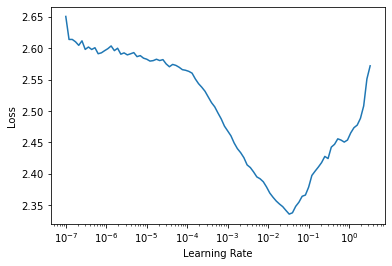

In [10]:
learn.lr_find()
# learn.recorder.plot()

In [ ]:
# save = SaveModelCallback(learn, monitor='accuracy', name='model_0')
#learn.fit_flat_cos(150, 3e-3, wd=1e-4)
learn.fit_one_cycle(250, 1e-3, wd=4e-4) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.922098,1.678994,0.615100,0.384900,01:52
1,1.821920,1.510680,0.539100,0.460900,01:20
2,1.720874,1.395401,0.498100,0.501900,01:20
3,1.692771,1.346841,0.475300,0.524700,01:21
4,1.634666,1.288059,0.450900,0.549100,01:21
5,1.584406,1.217381,0.431500,0.568500,01:20
6,1.575019,1.244090,0.436600,0.563400,01:20
7,1.549614,1.137571,0.397100,0.602900,01:21
8,1.481120,1.119291,0.393200,0.606800,01:20
9,1.515211,1.065781,0.371000,0.629000,01:19


Better model found at epoch 0 with accuracy value: 0.3849000036716461.
Better model found at epoch 1 with accuracy value: 0.4609000086784363.
Better model found at epoch 2 with accuracy value: 0.5019000172615051.
Better model found at epoch 3 with accuracy value: 0.5246999859809875.
Better model found at epoch 4 with accuracy value: 0.5490999817848206.
Better model found at epoch 5 with accuracy value: 0.5684999823570251.
Better model found at epoch 7 with accuracy value: 0.6029000282287598.
Better model found at epoch 8 with accuracy value: 0.6068000197410583.
Better model found at epoch 9 with accuracy value: 0.6290000081062317.
Better model found at epoch 10 with accuracy value: 0.6302000284194946.
Better model found at epoch 11 with accuracy value: 0.6366000175476074.
Better model found at epoch 12 with accuracy value: 0.6565999984741211.
Better model found at epoch 13 with accuracy value: 0.6588000059127808.
Better model found at epoch 14 with accuracy value: 0.6757000088691711.
B

In [ ]:
####################### Testing ###########################

In [ ]:
# graph_dir = 'comp_graphs/new/*.dot' #'/content/mnt/My Drive/Colab Notebooks/ResearchProject/comp_graphs/experiment_1/best/indv_1/*.dot'
# graph = [AGraph(g) for g in glob.glob(graph_dir)]
# _, comp_graph = cell_graph.generate_comp_graph(graph)

# comp_graphs = []
# for i in range(3):
#     graph = [AGraph(g) for g in glob.glob('comp_graphs/new/{}/*.dot'.format(i))]
#     _, comp_graph = cell_graph.generate_comp_graph(graph)#
#     comp_graphs.append(comp_graph)

graph = [AGraph(g) for g in glob.glob('comp_graphs/new/*.dot')]
_, comp_graph = cell_graph.generate_comp_graph(graph)#

In [ ]:
conf = arch_config(comp_graphs=comp_graphs,
                   #depth_coeff=1.0,
                   #width_coeff=1.0,
                   channels=40,
                   repeat_list=[3, 2, 3],
                   classes=10)

net = get_net(conf)
count_parameters(net)

In [ ]:
tfms = get_transforms(do_flip=False)
path = untar_data(URLs.CIFAR)
bs = 256

data = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

In [ ]:
model_dir = '/home/cliff/ResearchProjects/geppy_nn/comp_graphs/new' #'/content/mnt/My Drive/Colab Notebooks/ResearchProject/models/'
model = Learner(data, net, metrics=[accuracy, error_rate]).load(model_dir+'/model_1')
model.validate()

In [ ]:
preds,y,losses = model.get_preds(ds_type=DatasetType.Valid, with_loss=True)
preds[:5]